# **DistilBERT for Sarcasm detection**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install transformers
from transformers import get_linear_schedule_with_warmup
from tokenizers.processors import BertProcessing
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import statistics
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import tqdm
import nltk
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 23.5 MB/s 
     |████████████████████████████████| 182 kB 56.0 MB/s 
     |████████████████████████████████| 7.6 MB 64.1 MB/s 


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!unzip files.zip

Archive:  files.zip
   creating: files/
  inflating: files/train_labels.npy  
  inflating: files/responses.npy     


Truncate data

In [ ]:
responses = np.load('files/responses.npy')
responses = responses[:60000]
train_labels = np.load('files/train_labels.npy')
train_labels = train_labels[:60000]

In [ ]:
comment_label = np.array([a[0] for a in train_labels])
responses_concat = np.array([a[0] + '. '+ a[1] for a in responses])

In [ ]:
def make_words(s):
  w = s.split(' ')
  return ' '.join(w[:500])

In [ ]:
dict_df = {'text' : responses_concat, 'target' : comment_label}
full_df = pd.DataFrame(dict_df)
full_df['text_len'] = full_df['text'].apply(lambda x: len(make_words(x)))
full_df['text'] = full_df['text'].apply(lambda x: make_words(x))
full_df = full_df[full_df['text_len']<510]

In [ ]:
full_df = full_df[['text', 'target']]
full_df['target'] = full_df['target'].astype(np.int64)
full_df['text'] = full_df['text'].astype(str)

In [ ]:
full_df.head()

,text,target
0,religion must have the answer,1
1,wow...he smoked pot...oh lord hes such a horri...,1
2,i think the government should track every morm...,0
3,"oh right, *both* wars were just jewish conspir...",1
4,good luck with that.,1


Preprocess

In [ ]:
import pandas as pd
import numpy as np
import sys
from functools import partial
import time

In [ ]:
#divide data into train, validation, and test datasets
num_com = len(full_df)
idxs = list(range(num_com))
print('Total comments in dataset: ', num_com)
test_idx = idxs[:int(0.1*num_com)]
val_idx = idxs[int(0.1*num_com):int(0.2*num_com)]
train_idx = idxs[int(0.2*num_com):]

train_df = full_df.iloc[train_idx].reset_index(drop=True)
val_df = full_df.iloc[val_idx].reset_index(drop=True)
test_df = full_df.iloc[test_idx].reset_index(drop=True)

train_data = train_df[['text', 'target']]
val_data   = val_df[['text', 'target']]
test_data  = test_df[['text', 'target']]

Total tweets in dataset:  59987


In [ ]:
#Defining torch dataset class for disaster tweet dataset
class SARCDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx]

In [ ]:
#set up train, validation, and testing datasets
train_dataset = SARCDataset(train_data)
val_dataset   = SARCDataset(val_data)
test_dataset  = SARCDataset(test_data)

In [ ]:
def transformer_collate_fn(batch, tokenizer):
  bert_vocab = tokenizer.get_vocab()
  bert_pad_token = bert_vocab['[PAD]']
  bert_unk_token = bert_vocab['[UNK]']
  bert_cls_token = bert_vocab['[CLS]']
  
  sentences, labels, masks = [], [], []
  for data in batch:
    tokenizer_output = tokenizer([data['text']], max_length = 600, truncation=True)
    tokenized_sent = tokenizer_output['input_ids'][0]
    mask = tokenizer_output['attention_mask'][0]
    sentences.append(torch.tensor(tokenized_sent))
    labels.append(torch.tensor(data['target']))
    masks.append(torch.tensor(mask))
  sentences = pad_sequence(sentences, batch_first=True, padding_value=bert_pad_token)
  labels = torch.stack(labels, dim=0)
  masks = pad_sequence(masks, batch_first=True, padding_value=0.0)
  return sentences, labels, masks

In [ ]:
#computes the amount of time that a training epoch took and displays it in human readable form
def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#count the number of trainable parameters in the model
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
#train a given model, using a pytorch dataloader, optimizer, and scheduler (if provided)
def train(model,
          dataloader,
          optimizer,
          device,
          clip: float,
          scheduler = None):

    model.train()

    epoch_loss = 0

    for batch in dataloader:
        sentences, labels, masks = batch[0], batch[1], batch[2]

        optimizer.zero_grad()

        output = model(sentences.to(device), masks.to(device))
        loss = F.cross_entropy(output, labels.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        if scheduler is not None:
          scheduler.step()
          
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [ ]:
#calculate the loss from the model on the provided dataloader
def evaluate(model,
             dataloader,
             device):

    model.eval()

    epoch_loss = 0
    with torch.no_grad():
      for batch in dataloader:
          sentences, labels, masks = batch[0], batch[1], batch[2]
          output = model(sentences.to(device), masks.to(device))
          loss = F.cross_entropy(output, labels.to(device))
            
          epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

In [ ]:
#calculate the prediction accuracy on the provided dataloader
def evaluate_acc(model,
                 dataloader,
                 device):

    model.eval()

    epoch_loss = 0
    with torch.no_grad():
      total_correct = 0
      total = 0
      for i, batch in enumerate(dataloader):
          
          sentences, labels, masks = batch[0], batch[1], batch[2]
          output = model(sentences.to(device), masks.to(device))
          output = F.softmax(output, dim=1)
          output_class = torch.argmax(output, dim=1)
          total_correct += torch.sum(torch.where(output_class == labels.to(device), 1, 0))
          total += sentences.size()[0]

    return total_correct / total

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.6 MB/s 


In [ ]:
from torchmetrics.classification import BinaryF1Score
f1_score = BinaryF1Score().to(device)

In [ ]:
#calculate the prediction accuracy on the provided dataloader
def evaluate_f1(model,
                 dataloader,
                 device):

    model.eval()

    epoch_loss = 0
    with torch.no_grad():
      total_correct = 0
      total = 0
      preds = []
      labs = []
      for i, batch in enumerate(dataloader):
          
          sentences, labels, masks = batch[0], batch[1], batch[2]
          output = model(sentences.to(device), masks.to(device))
          output = F.softmax(output, dim=1)
          output_class = torch.argmax(output, dim=1)
          
          preds.append(output_class)
          labs.append(labels)
      
      preds = torch.cat(preds).to(device)
      labs = torch.cat(labs).to(device)
    return f1_score(preds, labs)

In [ ]:
bert_model_name = 'distilbert-base-uncased' 

##YOUR CODE HERE##

from transformers import DistilBertModel, DistilBertTokenizer
bert_model = DistilBertModel.from_pretrained(bert_model_name)
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
class SARCClassifier(nn.Module):
    def __init__(self,
                 bert_encoder: nn.Module,
                 enc_hid_dim=768, #default embedding size
                 outputs=2,
                 dropout=0.1):
        super().__init__()

        self.bert_encoder = bert_encoder

        self.enc_hid_dim = enc_hid_dim
        
        ### YOUR CODE HERE ### 
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(enc_hid_dim, outputs)

    def forward(self,
                src,
                mask):
        bert_output = self.bert_encoder(src, mask)

        ### YOUR CODE HERE ###
        #output = self.bert_encoder(src, mask, return_dict = False)

        output = self.dropout(bert_output[0])

        output = self.fc(torch.max(output, dim = 1)[0])

        #print(output.shape)

        return output

In [ ]:
def init_weights(m: nn.Module, hidden_size=768):
    k = 1/hidden_size
    for name, param in m.named_parameters():
        if 'weight' in name:
            print(name)
            nn.init.uniform_(param.data, a=-1*k**0.5, b=k**0.5)
        else:
            print(name)
            nn.init.uniform_(param.data, 0)

In [ ]:
def init_classification_head_weights(m: nn.Module, hidden_size=768):
    k = 1/hidden_size
    for name, param in m.named_parameters():
        #if param.shape == torch.Size([2, 768]) or param.shape == torch.Size([2]):
        if name == "fc.weight":
          print(name)
          nn.init.uniform_(param.data, a=-1*k**0.5, b=k**0.5)
        elif name == "fc.bias":
          print(name)
          nn.init.uniform_(param.data, 0)

In [ ]:
#define hyperparameters
BATCH_SIZE = 10
LR = 1e-5
WEIGHT_DECAY = 0
N_EPOCHS = 5
CLIP = 1.0

#define models, move to device, and initialize weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SARCClassifier(bert_model).to(device)
model.apply(init_classification_head_weights)
model.to(device)
print('Model Initialized')

fc.weight
fc.bias
Model Initialized


In [ ]:
#create pytorch dataloaders from train_dataset, val_dataset, and test_datset
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer), shuffle = True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,collate_fn=partial(transformer_collate_fn, tokenizer=tokenizer))

In [ ]:
Valid_f1 = []
Train_f1 = []
Valid_acc = []
Train_acc = []
Valid_loss = []
Train_loss = []
Epochs = [0]

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=N_EPOCHS*len(train_dataloader))

print(f'The model has {count_parameters(model):,} trainable parameters')

train_loss = evaluate(model, train_dataloader, device)
train_acc = evaluate_acc(model, train_dataloader, device)
train_f1 = evaluate_f1(model, train_dataloader, device)
Train_loss.append(train_loss)
Train_acc.append(train_acc)
Train_f1.append(train_f1)

valid_loss = evaluate(model, val_dataloader, device)
valid_acc = evaluate_acc(model, val_dataloader, device)
valid_f1 = evaluate_f1(model, val_dataloader, device)
Valid_loss.append(valid_loss)
Valid_acc.append(valid_acc)
Valid_f1.append(valid_f1)

print(f'Initial Train Loss: {train_loss:.3f}')
print(f'Initial Train Acc: {train_acc:.3f}')
print(f'Initial Train f1: {train_f1:.3f}')

print(f'Initial Valid Loss: {valid_loss:.3f}')
print(f'Initial Valid Acc: {valid_acc:.3f}')
print(f'Initial Valid f1: {valid_f1:.3f}')

for epoch in range(N_EPOCHS):
    Epochs.append(epochs)

    start_time = time.time()
    train_loss = train(model, train_dataloader, optimizer, device, CLIP, scheduler)
    Train_loss.append(train_loss)
    end_time = time.time()

    train_acc = evaluate_acc(model, train_dataloader, device)
    Train_acc.append(train_acc)

    train_f1 = evaluate_f1(model, train_dataloader, device)
    Train_f1.append(train_f1)

    valid_loss = evaluate(model, val_dataloader, device)
    Valid_loss.append(valid_loss)

    valid_acc = evaluate_acc(model, val_dataloader, device)
    Valid_acc.append(valid_acc)

    valid_f1 = evaluate_f1(model, val_dataloader, device)
    Valid_f1.append(valid_f1)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTrain Acc: {train_acc:.3f}')
    print(f'\tTrain f1: {train_f1:.3f}')

    print(f'\tValid Loss: {valid_loss:.3f}')
    print(f'\tValid Acc: {valid_acc:.3f}')
    print(f'\tValid f1: {valid_f1:.3f}')


The model has 66,364,418 trainable parameters
Initial Train Loss: 0.699
Initial Train Acc: 0.507
Initial Train f1: 0.600
Initial Valid Loss: 0.701
Initial Valid Acc: 0.500
Initial Valid f1: 0.594
Epoch: 01 | Time: 5m 10s
	Train Loss: 0.610
	Train Acc: 0.735
	Train f1: 0.712
	Valid Loss: 0.594
	Valid Acc: 0.681
	Valid f1: 0.652
Epoch: 02 | Time: 5m 19s
	Train Loss: 0.529
	Train Acc: 0.801
	Train f1: 0.812
	Valid Loss: 0.597
	Valid Acc: 0.682
	Valid f1: 0.700
Epoch: 03 | Time: 5m 18s
	Train Loss: 0.450
	Train Acc: 0.869
	Train f1: 0.869
	Valid Loss: 0.620
	Valid Acc: 0.684
	Valid f1: 0.682
Epoch: 04 | Time: 5m 20s
	Train Loss: 0.372
	Train Acc: 0.906
	Train f1: 0.905
	Valid Loss: 0.701
	Valid Acc: 0.680
	Valid f1: 0.674
Epoch: 05 | Time: 5m 19s
	Train Loss: 0.312
	Train Acc: 0.916
	Train f1: 0.916
	Valid Loss: 0.787
	Valid Acc: 0.674
	Valid f1: 0.675


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [ ]:
valid_f1 = [0.664, 0.664, 0.756, 0.761, 0.756, 0.754]
train_f1 = [0.665, 0.794, 0.851, 0.898, 0.925, 0.935]
valid_acc = [0.497, 0.738, 0.755, 0.759, 0.757, 0.757]
train_acc = [0.498, 0.792, 0.849, 0.898, 0.925, 0.925]
valid_loss = [0.760, 0.520, 0.514, 0.539, 0.592, 0.660]
train_loss = [0.762, 0.577, 0.451, 0.371, 0.299, 0.251]
epochs = [0, 1, 2, 3, 4, 5]

In [ ]:
l = [Valid_f1
,Train_f1
,Valid_acc
,Train_acc
]

In [ ]:
for i in l:
  for p in range(len(i)):
    i[p] = i[p].detach().cpu().numpy()

In [ ]:
for i in l:
  for p in range(len(i)):
    i[p] = int(i[p])

In [ ]:
Valid_f1 = [0.600, 0.712, 0.812, 0.869, 0.905, 0.916]
Train_f1 = [0.594, 0.652, 0.700, 0.682, 0.674, 0.675]
Valid_acc = [0.500, 0.681, 0.682, 0.684, 0.680, 0.674]
Train_acc = [0.507, 0.735, 0.801, 0.869, 0.906, 0.916]

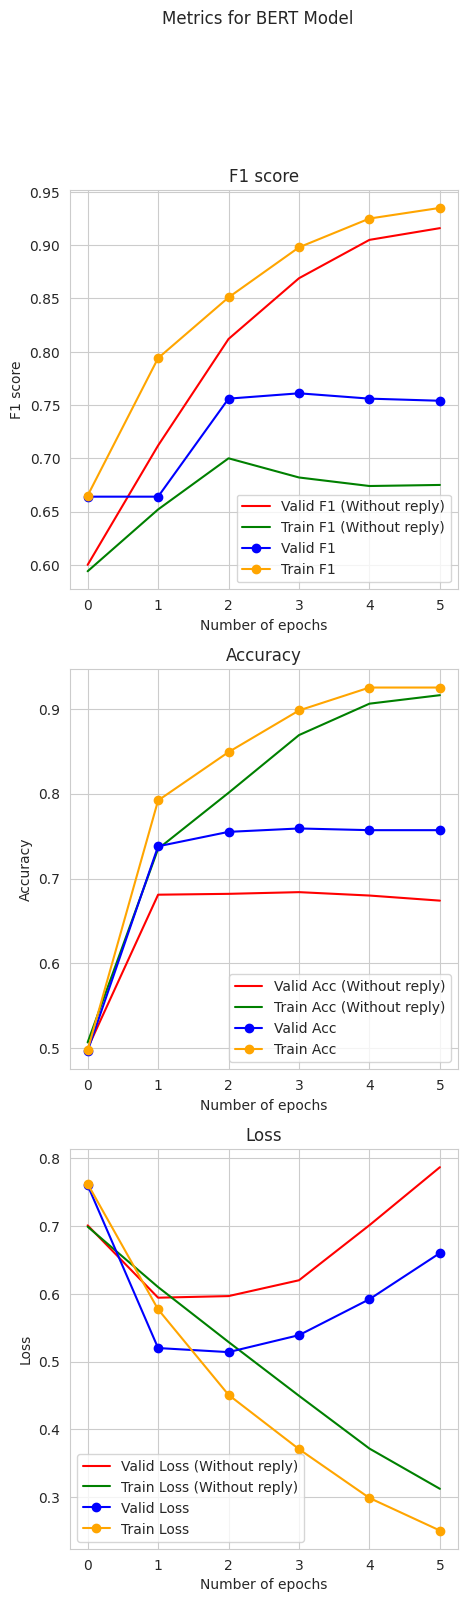

In [ ]:
fig, axs = plt.subplots(3, 1, figsize = (5, 18), dpi =100)
axs[0].plot(Epochs, Valid_f1, label = 'Valid F1 (Without reply)', color = 'r')
axs[0].plot(Epochs, Train_f1, label = 'Train F1 (Without reply)', color = 'g')
axs[0].plot(Epochs, valid_f1, label = 'Valid F1', color = 'b', marker = 'o')
axs[0].plot(Epochs, train_f1, label = 'Train F1', color = 'orange', marker = 'o')

axs[0].legend()
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('F1 score')
axs[0].set_title('F1 score')
# axs.set_xticklabels(labels = [0, 1, 2, 3, 4, 5])

axs[1].plot(Epochs, Valid_acc, label = 'Valid Acc (Without reply)', color = 'r')
axs[1].plot(Epochs, Train_acc, label = 'Train Acc (Without reply)', color = 'g')
axs[1].plot(Epochs, valid_acc, label = 'Valid Acc', marker = 'o', color = 'b')
axs[1].plot(Epochs, train_acc, label = 'Train Acc', marker = 'o', color = 'orange')

axs[1].legend()
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')

axs[2].plot(Epochs, Valid_loss, label = 'Valid Loss (Without reply)', color = 'r')
axs[2].plot(Epochs, Train_loss, label = 'Train Loss (Without reply)', color = 'g')
axs[2].plot(Epochs, valid_loss, label = 'Valid Loss', marker = 'o', color = 'b')
axs[2].plot(Epochs, train_loss, label = 'Train Loss', marker = 'o', color = 'orange')
axs[2].set_title('Loss')

axs[2].legend()
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Loss')

# fig.tight_layout()
fig.suptitle('Metrics for BERT Model')
plt.savefig('Bert_Com.png', dpi=100)